In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt
import pyomo.environ as pe

from scipy.stats import rv_histogram

import nice
from nice.reload import deep_reload

In [2]:
'''
Loading data
'''

atlas = nice.graph.graph_from_json('Data/reduced_atlas.json')

graph_all = nice.graph.graph_from_json('Data/graph_100k.json')
graph_ccs = nice.graph.graph_from_json('Data/graph_ccs_100k.json')
graph_nacs = nice.graph.graph_from_json('Data/graph_nacs_100k.json')

paths_all = json.load(open('Data/paths_100k.json', 'r'))
paths_ccs = json.load(open('Data/paths_ccs_100k.json', 'r'))
paths_nacs = json.load(open('Data/paths_nacs_100k.json', 'r'))

In [3]:
'''
Adding cost field to edges
'''

graph = graph_ccs
paths = paths_ccs

for source, _adj in graph._adj.items():
    for target, edge in _adj.items():

        edge['cost'] = edge['time']

In [4]:
'''
Removing direct paths
'''

paths = [p for p in paths if len(p['path']) > 2]

In [5]:
'''
Labeling places and stations
'''

places = [k for k, n in graph._node.items() if 'station' not in k]
stations = [k for k, n in graph._node.items() if 'station' in k]

In [6]:
'''
Setting travel demand
'''
deep_reload(nice)

p = [ 0.00890009, -0.00686443]
f = lambda d: p[0] * np.exp(p[1] * d)

kw = {
    'routing_weight': 'time',
    'production': 'population',
}

graph = nice.demand.demand(graph, places, **kw)

In [7]:
'''
Adding charging information at stations
'''
deep_reload(nice)

rng = np.random.default_rng(26589763514)

energy = 35 * 3.6e6
rho = np.concatenate(
    (
        np.linspace(0, .5, 2),
        np.linspace(.51, .99, 10),
        np.linspace(.991, .999, 10)
    )
)

delta = 10

for station in stations:

    node = graph._node[station]

    power = node['power_kw'] * 1e3
    m = 1 / (energy / power)
    n = node['port_count']

    lower_bound = n
    upper_bound = n + delta if n > 3 else n
    c = list(range(lower_bound, upper_bound + 1, 5))

    queue = nice.queue.Queue(m = m, rho = rho, c = c)
    
    volumes = np.array([rho * m * size for size in c])
    delays =  np.array(
        [queue.interpolate(rho, size)[0] * rho * m * size for size in c]
    )

    counts = np.array([c for c in c])
    expenditure = np.array([c - n for c in c])

    graph._node[station]['power'] = power
    graph._node[station]['volumes'] = np.atleast_2d(volumes)
    graph._node[station]['delays'] = np.atleast_2d(delays * 3600 / (1 / volumes))
    graph._node[station]['counts'] = counts
    graph._node[station]['expenditures'] = expenditure

In [8]:
'''
Adding classes and Building the network
'''
deep_reload(nice)

for place in places:

    graph._node[place]['_class'] = nice.optimization.Place

for station in stations:

    graph._node[station]['_class'] = nice.optimization.Station

for source, _adj in graph._adj.items():
    for target, edge in _adj.items():

        edge['cost'] = edge['time']
        edge['_class'] = nice.optimization.Edge

for path in paths:
    
    path['_class'] = nice.optimization.Path

kw = {
    'verbose': True,
}

network = nice.optimization.Network(**kw).from_graph(graph, paths)

network.build()

Objects Built: 2.7817656993865967
Sets Built: 0.050412654876708984
Parameters Built: 0.8493375778198242
Variables Built: 0.5541791915893555
Constraints Built: 0.2284243106842041
Expenditure Built: 0.05187225341796875
Objective Built: 0.4866516590118408


In [9]:
'''
Solving the model
'''
deep_reload(nice)

kw = {
    'solver': {
        '_name': 'appsi_highs',
        'time_limit': 60 * 5,
    },
}

scale = 2e4
duration = 3600

network.model.scale = scale
network.model.duration = duration
network.model.penalty = 1
network.model.expenditure = 25

network.solve(**kw)
solution = network.solution

print('Objective Value:', network.objective_value / scale / 3600)

Problem Solved: 28.87496066093445
Results Collected: 0.4898395538330078
Objective Value: 0.3820590046123621


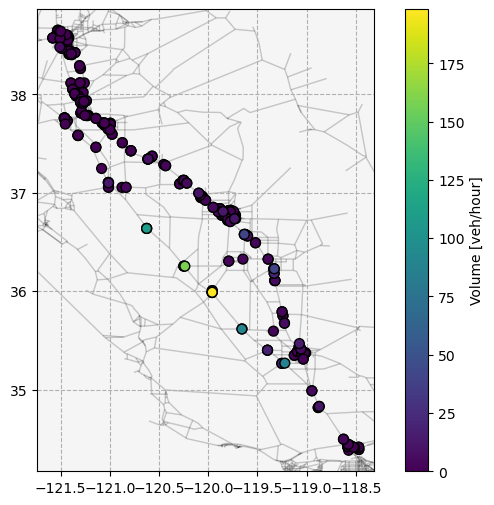

In [10]:
'''
Plotting station volume
'''
deep_reload(nice)

fig, ax = plt.subplots(figsize = (8, 6))

for station in stations:
    
    node = solution._node[station]

    node['volume_h'] = node.get('volume', 0) * 3600
    node['delta'] = node.get('selection', 0) - node.get('port_count', 0)

kw = {
    'nodes': {
        'selection': (
            [s for s in stations if solution._node[s]['delta'] > 0]
        ),
        'selection': stations,
        'field': 'volume_h',
        'colorbar': {
            'label': 'Volume [veh/hour]',
        },
        'plot': {
            's': 50,
            'zorder': 2,
            'ec': 'k',
        },
    },
}
    
sm = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'edges': {
        'plot': {
            'lw': 1,
            'color': 'k',
            'alpha': .1,
            'zorder': 0,
        },
    },     
}
    
_ = nice.plot.plot_graph(atlas, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

ax.set_aspect('equal')

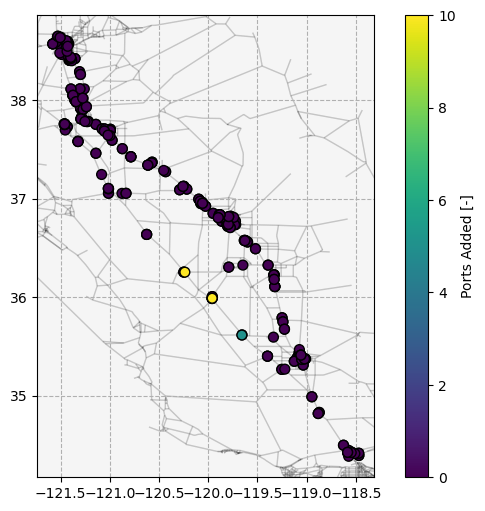

In [11]:
'''
Plotting ports added
'''
deep_reload(nice)

fig, ax = plt.subplots(figsize = (8, 6))

for station in stations:
    
    node = solution._node[station]
    
    node['delta'] = node.get('selection', 0) - node.get('port_count', 0)

kw = {
    'nodes': {
        'selection': (
            [s for s in stations if solution._node[s]['delta'] > 0]
        ),
        'selection': stations,
        'field': 'delta',
        'colorbar': {
            'label': 'Ports Added [-]',
        },
        'plot': {
            's': 50,
            'zorder': 2,
            'ec': 'k',
        },
    },
}
    
sm = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'edges': {
        'plot': {
            'lw': 1,
            'color': 'k',
            'alpha': .1,
            'zorder': 0,
        },
    },     
}
    
_ = nice.plot.plot_graph(atlas, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

ax.set_aspect('equal')